In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels.api as sm


from typing import Union
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

from itertools import product


import torch
from torchmetrics.regression import MeanAbsoluteError
from torchmetrics import MeanAbsolutePercentageError

plt.rcParams['font.family'] = 'AppleGothic'

np.random.seed(42)

In [ ]:
columns = {
    'realgdp': '실질GDP/ Real GDP',
    'realcons': '실질 개인 소비 지출/ Real personal consumption expenditure',
    'realinv': '실질 국내 총 민간 투자/ Real domestic gross private investment',
    'realgovt': '실질 연방 소비 지출 및 투자/ Real Federal Consumer Spending and Investment',
    'realdpi': '실질 민간 가처분 소득/ Real private disposable income',
    'cpi': '분기 말 소비자물가지수/ Consumer Price Index at the end of the quarter',
    'm1': 'M1 명목 통화량/ M1 nominal money supply',
    'tbilrate': '3개월 만기 국채의 분기별 월평균 금리/ Quarterly average monthly interest rate on 3-month Treasury bonds',
    'unemp': '실업률/ Unemployment rate',
    'pop': '분기 말 총인구/ Total population at the end of the quarter',
    'infl': '인플레이션율/ Inflation rate',
    'realint' '실질 이자율/ Real interest rate'
}

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [3]:
 np.arange(0, 204, 4),  np.arange(1959, 2010, 1) 

(array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
         52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
        104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152,
        156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200]),
 array([1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
        1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
        1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
        1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
        2003, 2004, 2005, 2006, 2007, 2008, 2009]))

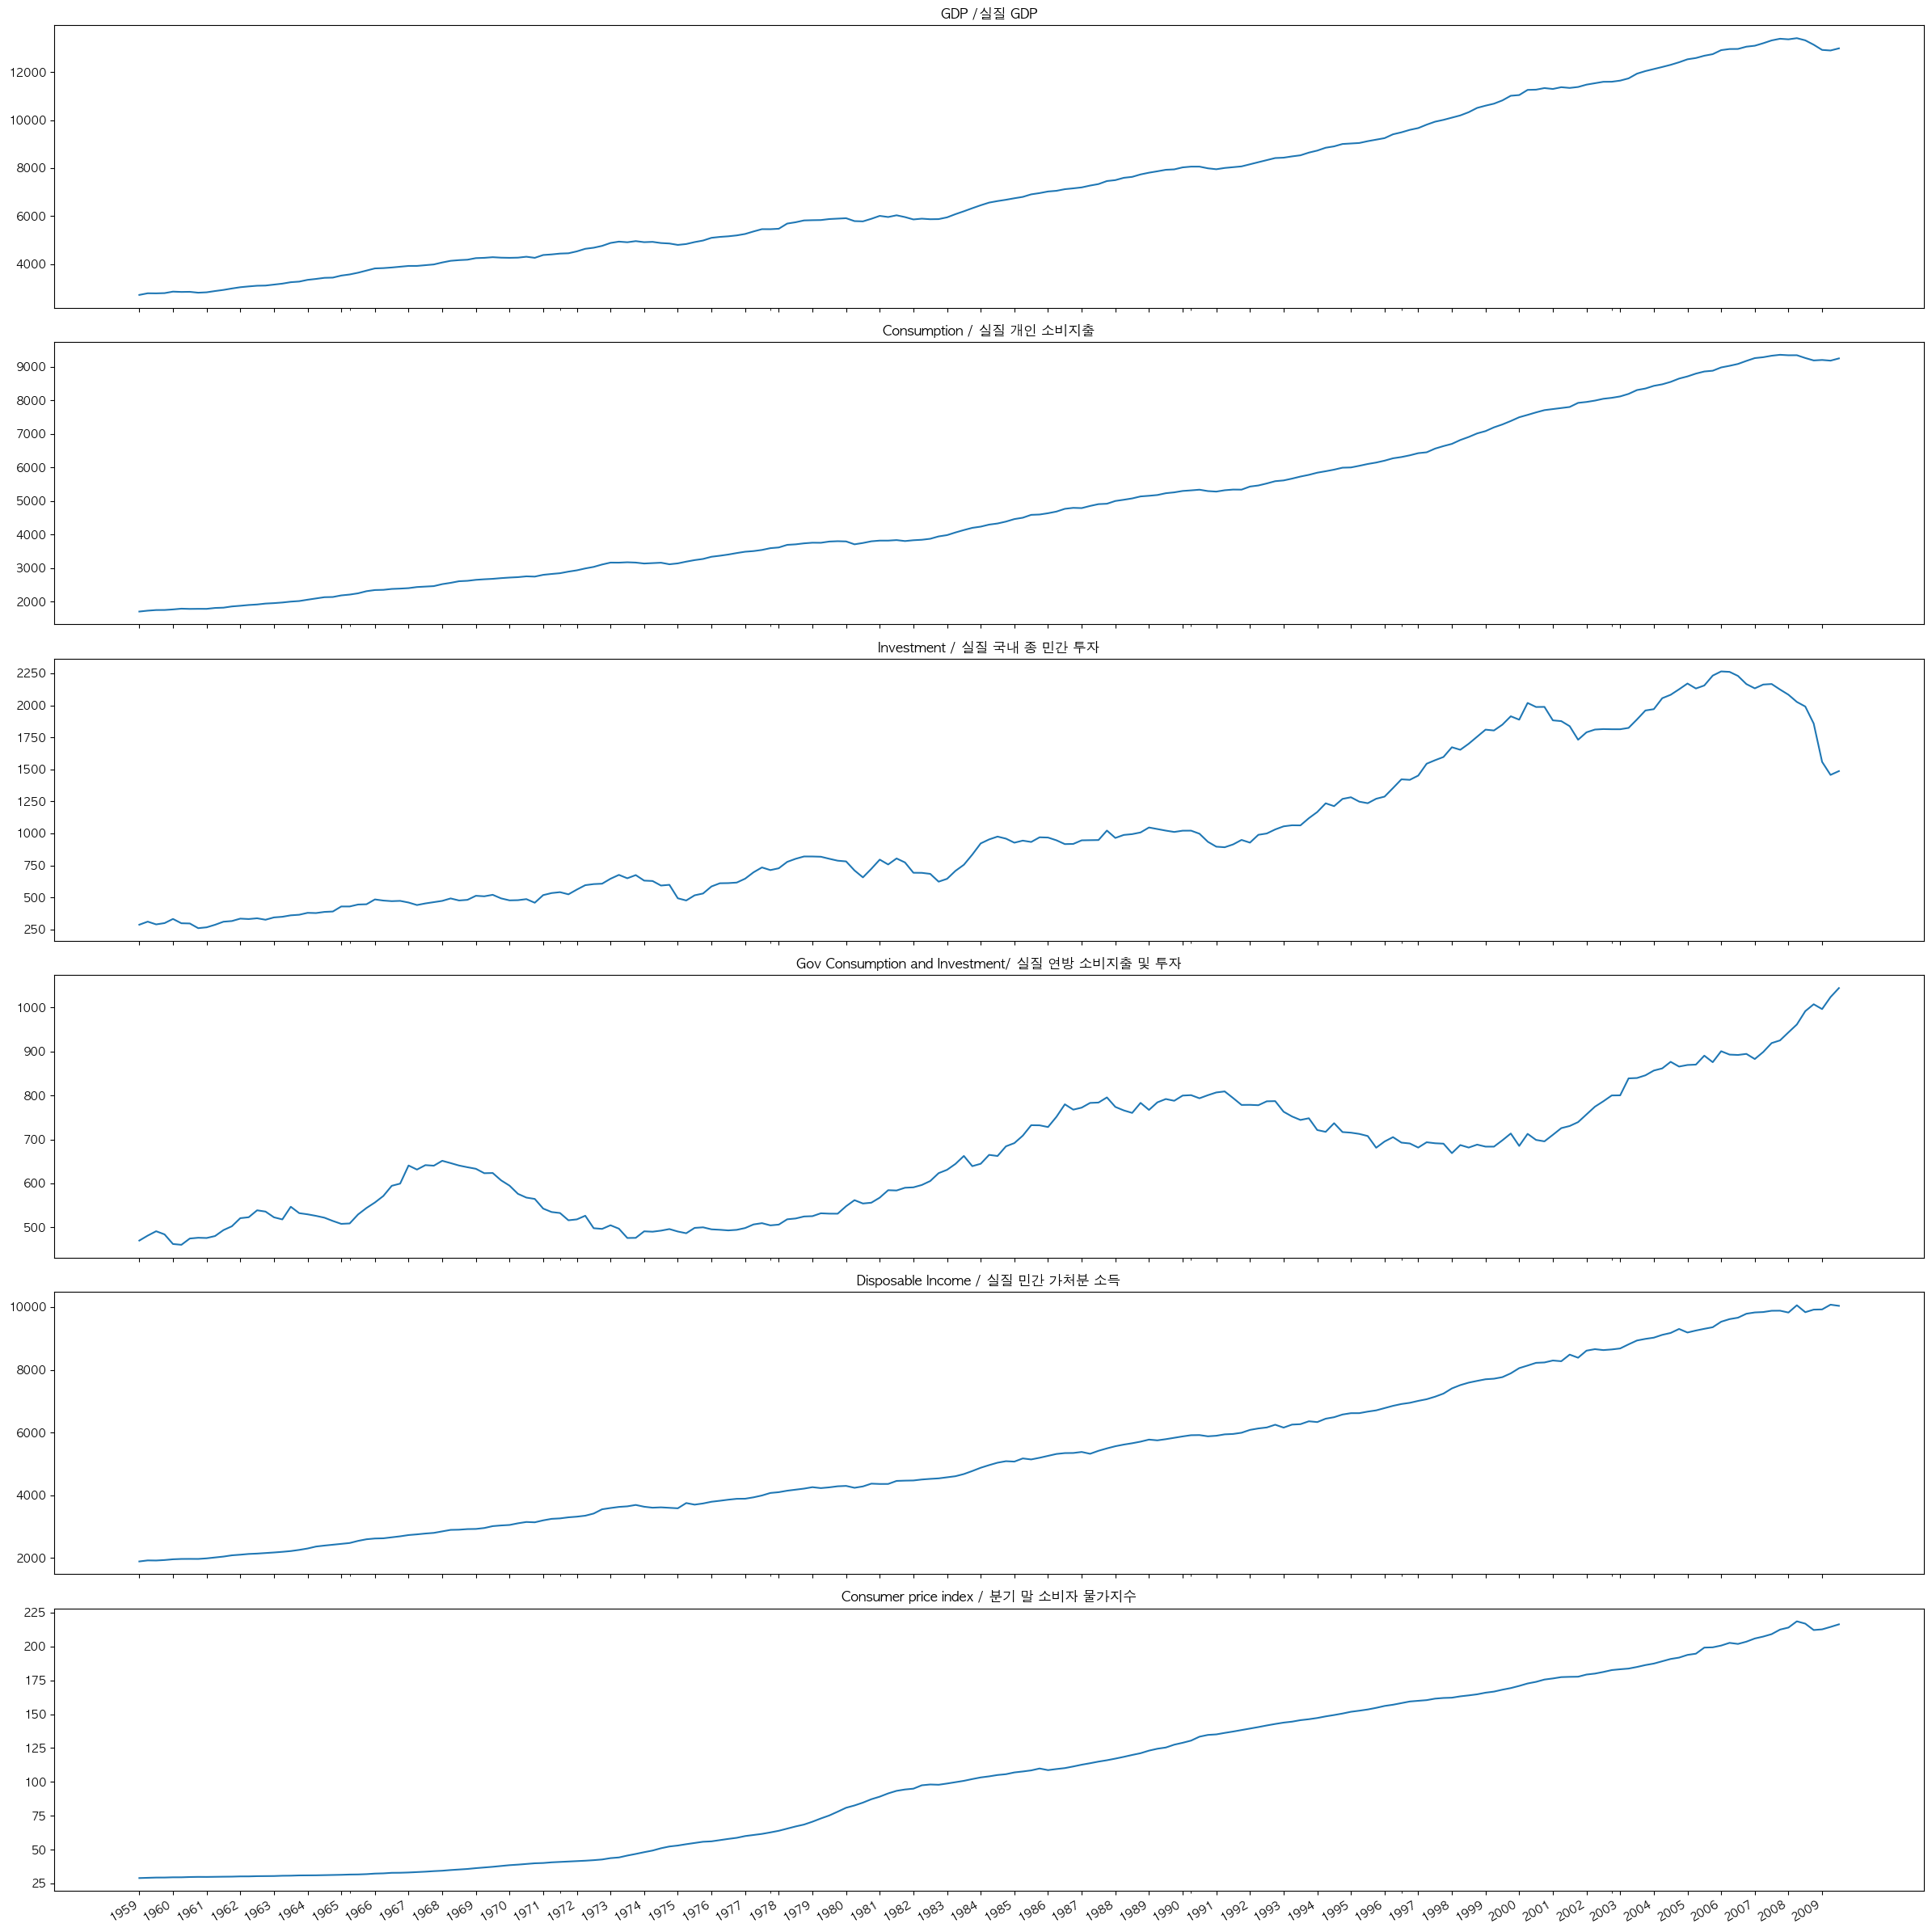

In [4]:
fig, (ax1, ax2, ax3, ax4 , ax5, ax6) = plt.subplots(6, 1, sharex=True, figsize=(24,24))

macro_econ_data.realgdp.plot( ax = ax1)
macro_econ_data.realcons.plot( ax = ax2)
macro_econ_data.realinv.plot( ax = ax3)
macro_econ_data.realgovt.plot( ax = ax4)
macro_econ_data.realdpi.plot( ax = ax5)
macro_econ_data.cpi.plot( ax = ax6)

ax1.set_title('GDP /실질 GDP')
ax2.set_title('Consumption / 실질 개인 소비지출')
ax3.set_title('Investment / 실질 국내 종 민간 투자')
ax4.set_title('Gov Consumption and Investment/ 실질 연방 소비지출 및 투자')
ax5.set_title('Disposable Income / 실질 민간 가처분 소득')
ax6.set_title('Consumer price index / 분기 말 소비자 물가지수')

plt.xticks( np.arange(0, 204, 4),  np.arange(1959, 2010, 1)  )
fig.autofmt_xdate()
plt.tight_layout()

In [96]:
#target = macro_econ_data['realgdp']
#exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]


target = macro_econ_data.iloc[:, [2] ]
exog = macro_econ_data.iloc[:, list(range( 3,8, 1)) ]


In [97]:
ad_fuller_result = adfuller(target)
ad_fuller_result

(1.7504627967647095,
 0.9982455372335032,
 12,
 190,
 {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 2034.517123668382)

In [98]:
target_diff = target.diff()
ad_fuller_result = adfuller(target_diff[1:])
ad_fuller_result

(-6.305695561658102,
 3.327882187668259e-08,
 1,
 200,
 {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225},
 2024.992358126391)

In [99]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [100]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4


parameters_list = list(product(p, q, P, Q))

target_train = target[:202]
exog_train = exog[:202]


In [59]:
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 3, 0, 0)",1766.478367
1,"(3, 3, 0, 0)",1768.120975
2,"(3, 3, 2, 2)",1768.895437
3,"(3, 3, 0, 1)",1769.881545
4,"(3, 3, 1, 0)",1769.911724
...,...,...
251,"(2, 2, 3, 2)",1792.994017
252,"(3, 2, 2, 1)",1793.053041
253,"(3, 2, 1, 3)",1793.612197
254,"(3, 2, 3, 1)",1794.861864


In [60]:
best_model = SARIMAX(target_train, exog_train, order=(2,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  202
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -872.239
Date:                Fri, 16 Aug 2024   AIC                           1766.478
Time:                        14:19:26   BIC                           1802.815
Sample:                             0   HQIC                          1781.182
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9774      0.047     20.711      0.000       0.885       1.070
realinv        0.9637      0.027     36.293      0.000       0.912       1.016
realgovt       0.7300      0.123      5.942      0.0

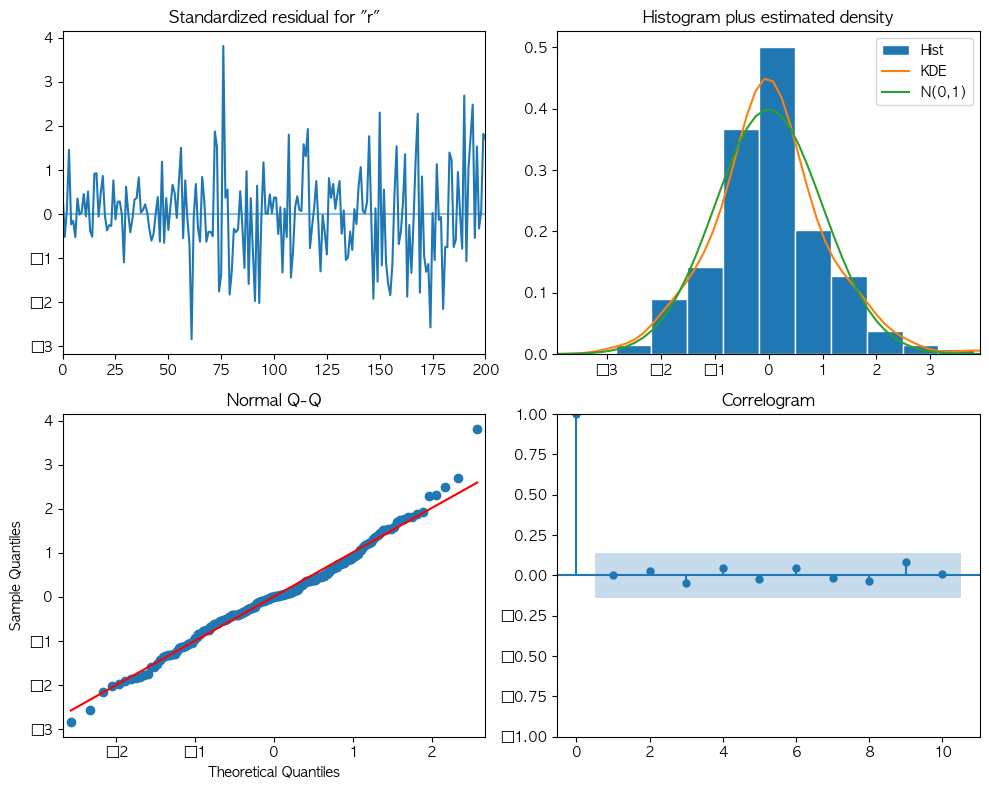

In [61]:
best_model_fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

In [62]:
residuals = best_model_fit.resid
tr = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(tr)

     lb_stat  lb_pvalue
1   0.056716   0.811764
2   0.059025   0.970919
3   0.225337   0.973399
4   1.643487   0.800956
5   1.733607   0.884639
6   1.876163   0.930728
7   2.041980   0.957480
8   2.061139   0.979080
9   2.758918   0.973091
10  2.768191   0.986365


In [119]:
def getPred(target: Union[pd.Series, list], exog:Union[pd.Series, list], start:int, end:int)-> pd.DataFrame:
    pred_df = pd.DataFrame({'actual': target.loc[start:end, 'realgdp' ].values })
    pred_df['pred_last_value'] = target.loc[start-1:end-1, 'realgdp' ].values 
    
    pred_SARIMAX = []
    for i in range(start, end+1, 1):
        #pred_SARIMAX.append( best_model_fit.get_prediction( i, i,   exog=[ exog.iloc[i:] ]    ).predicted_mean.item() )
        model = SARIMAX(target[:i], exog[:i], order=(2,1,2), seasonal_order=(0,0,0,4), simple_differencing=False).fit(disp=False)
        pred_SARIMAX.append( model.get_prediction( i, i,   exog= exog[i:i+1]   ).predicted_mean.item() )
        
    pred_df['pred_SARIMAX'] = pred_SARIMAX
    
    return pred_df
    

In [120]:
pred_df = getPred(target=target, exog=exog, start=196, end=202)
pred_df.index = list(range(196,203,1))
pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13376.846288
197,13415.266,13366.865,13360.590919
198,13324.600,13415.266,13336.467123
199,13141.920,13324.600,13134.456162
200,12925.410,13141.920,12886.457267
201,12901.504,12925.410,12853.913170
202,12990.341,12901.504,13014.827668


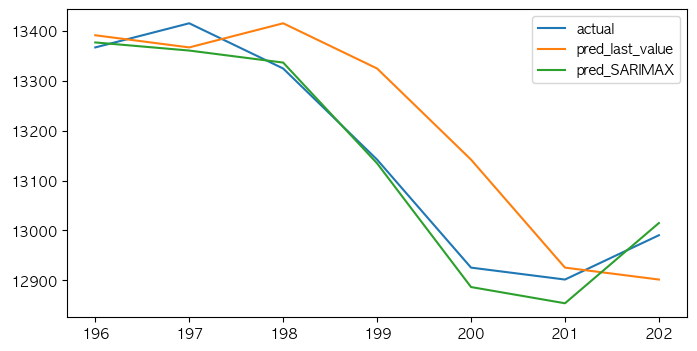

In [121]:
ax = pred_df.plot( figsize=(8,4),  layout='constrained')

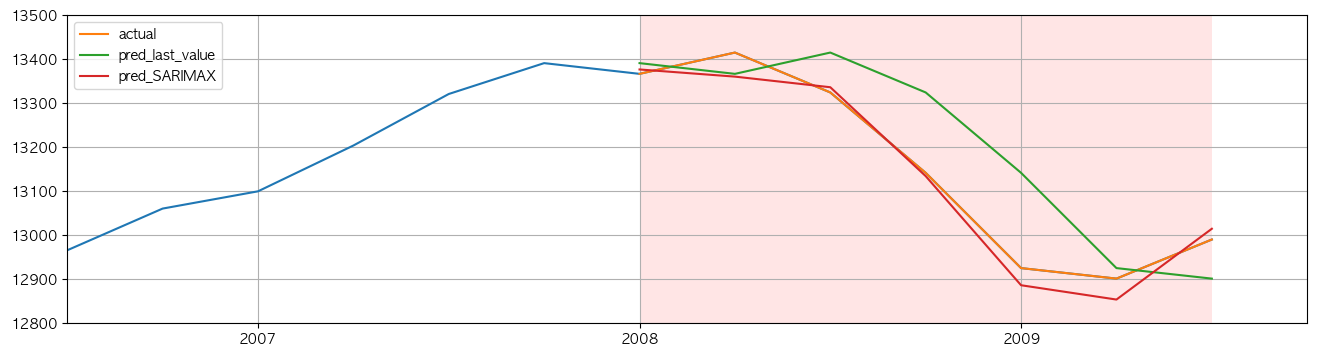

In [122]:
ax = target.realgdp.plot( figsize=(16,4),  layout='constrained' )
ax.axvspan(196, 202, facecolor='red', alpha=0.1)
ax.set_xticks( np.arange(0, 204, 4),  np.arange(1959, 2010, 1)  )
ax.set_xlim(190, 203)
ax.set_ylim(12800, 13500)
pred_df.plot( ax = ax)
ax.grid()
plt.show()

In [123]:
mean_abs_percentage_error = MeanAbsolutePercentageError()
mapes = {}

pred_last_value = torch.FloatTensor( pred_df['pred_last_value'].values)
pred_SARIMAX = torch.FloatTensor( pred_df['pred_SARIMAX'].values)
actual = torch.FloatTensor(pred_df['actual'].values)


mapes['mape_naive_seasonal'] = mean_abs_percentage_error( pred_last_value, actual).item()
mapes['mape_SARIMAX'] = mean_abs_percentage_error( pred_SARIMAX, actual ).item()
mapes

{'mape_naive_seasonal': 0.0073684826493263245,
 'mape_SARIMAX': 0.0021240527275949717}

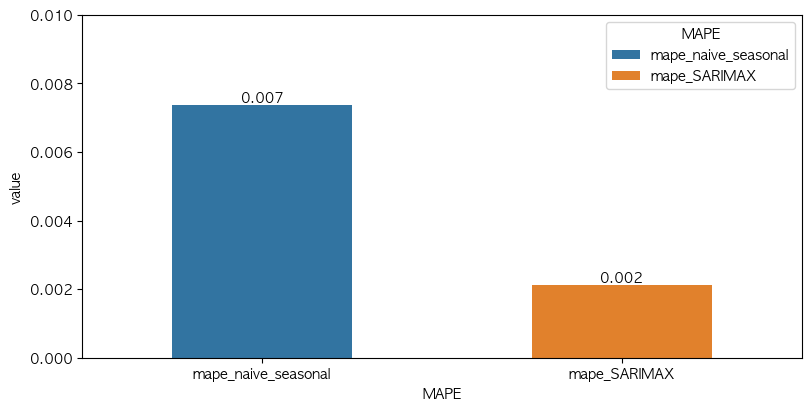

In [124]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([mapes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )
ax.set_ylim(0, 0.01)
ax.set_xlabel('MAPE')
ax.legend(title='MAPE')
for index, label in enumerate(mapes):   
    ax.bar_label(ax.containers[index], fmt='%.3f',  fontsize=10)

In [125]:
mean_absolute_error = MeanAbsoluteError()

maes = {}

pred_last_value = torch.FloatTensor( pred_df['pred_last_value'].values)
pred_SARIMAX = torch.FloatTensor( pred_df['pred_SARIMAX'].values)
actual = torch.FloatTensor(pred_df['actual'].values)


maes['mae_naive_seasonal'] =  mean_absolute_error( pred_last_value, actual ).item()
maes['mae_SARIMA'] = mean_absolute_error( pred_SARIMAX, actual ).item()
maes

{'mae_naive_seasonal': 96.48326110839844, 'mae_SARIMA': 27.859792709350586}

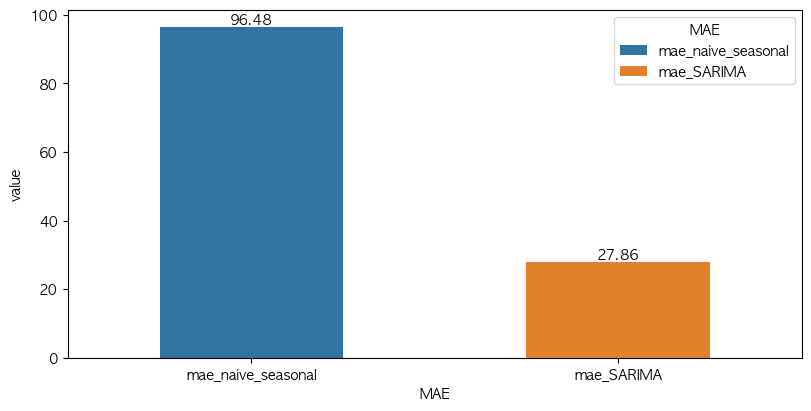

In [126]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([maes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )

ax.set_xlabel('MAE')
ax.legend(title='MAE')
for index, label in enumerate(maes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)